## BERT Embeddings on SMS Spam Dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from bert.tokenization import FullTokenizer
from tensorflow.keras.models import Model
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.0.0
Hub version:  0.7.0


In [34]:
max_seq_length = 256  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [35]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [36]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [37]:
def get_ids_masks_segmenets(sentence):
    stokens = tokenizer.tokenize(sentence)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    input_ids = get_ids(stokens, tokenizer, max_seq_length)
    input_masks = get_masks(stokens, max_seq_length)
    input_segments = get_segments(stokens, max_seq_length)
    return input_ids, input_masks, input_segments


def build_ids_masks_segments(sentences):
    input_ids_ = []
    input_masks_ = []
    input_segments_ = []
    for s in sentences:
        input_ids, input_masks, input_segments = get_ids_masks_segmenets(s)
        input_ids_.append(input_ids)
        input_masks_.append(input_masks)
        input_segments_.append(input_segments)
    return input_ids_, input_masks_, input_segments_

def get_embeddings(sentences):
    input_ids, input_masks, input_segments = build_ids_masks_segments(sentences)
    pool_embs, all_embs = model.predict([input_ids,input_masks,input_segments])
    return all_embs

In [38]:
print(get_embeddings(["hey", "yay"]).shape)

(2, 256, 768)


In [39]:
df = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'data'])
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [40]:
X = df['data']
X_train = X[0:int(X.shape[0]*.6)]
X_val = X[int(X.shape[0]*.6):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]


In [41]:
X_train = get_embeddings(X_train.values)
X_val = get_embeddings(X_val.values)
X_test = get_embeddings(X_test.values)

In [42]:
y = df['label']
y_train = y[0:int(y.shape[0]*.6)]
y_val = y[int(y.shape[0]*.6):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

HAM = 0
SPAM = 1

y_train = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_train)))
y_val = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_val)))
y_test = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_test)))

ham     2897
spam     446
Name: label, dtype: int64
ham     717
spam    119
Name: label, dtype: int64
ham     1211
spam     182
Name: label, dtype: int64


In [47]:
import tensorflow as tf
print(X_test.shape)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(X_test.shape[1], X_test.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5),
              metrics=['accuracy'])

(1393, 256, 768)


In [48]:
history = model.fit(x=X_train, y=y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    validation_steps=30)

Train on 3343 samples, validate on 836 samples
Epoch 1/10
3343/3343 [==============================] - 96s 29ms/sample - loss: 0.3519 - accuracy: 0.8687 - val_loss: 0.2256 - val_accuracy: 0.9324
Epoch 2/10
3343/3343 [==============================] - 99s 30ms/sample - loss: 0.1169 - accuracy: 0.9707 - val_loss: 0.0834 - val_accuracy: 0.9742
Epoch 3/10
3343/3343 [==============================] - 98s 29ms/sample - loss: 0.0578 - accuracy: 0.9827 - val_loss: 0.0575 - val_accuracy: 0.9839
Epoch 4/10
3343/3343 [==============================] - 98s 29ms/sample - loss: 0.0428 - accuracy: 0.9886 - val_loss: 0.0517 - val_accuracy: 0.9796
Epoch 5/10
3343/3343 [==============================] - 95s 28ms/sample - loss: 0.0348 - accuracy: 0.9907 - val_loss: 0.0395 - val_accuracy: 0.9903
Epoch 6/10
3343/3343 [==============================] - 75s 22ms/sample - loss: 0.0280 - accuracy: 0.9931 - val_loss: 0.0344 - val_accuracy: 0.9893
Epoch 7/10
3343/3343 [==============================] - 99s 30ms/

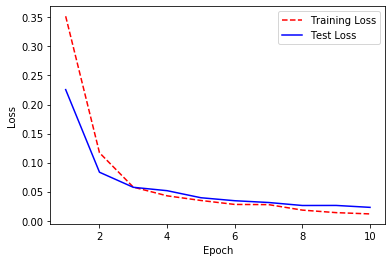

In [49]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [50]:
test_results = model.test_on_batch(
    X_test,
    y=y_test,
    sample_weight=None,
    reset_metrics=True
)
print(list(zip(model.metrics_names, test_results)))

[('loss', 0.046336617), ('accuracy', 0.99096775)]


In [51]:
y_pred = model.predict(X_test).round()
y_pred = list(map(lambda x: int(x[0]), y_pred))
confusion = tf.math.confusion_matrix(labels=y_test, predictions=y_pred, num_classes=2)
confusion = confusion.numpy()

In [56]:
fp = confusion[0][1]
tn = confusion[0][0]
fp_rate = float(fp / (fp+tn))
print(f"False Positive Rate: {round(fp_rate*100,3)}%")

False Positive Rate: 0.495%


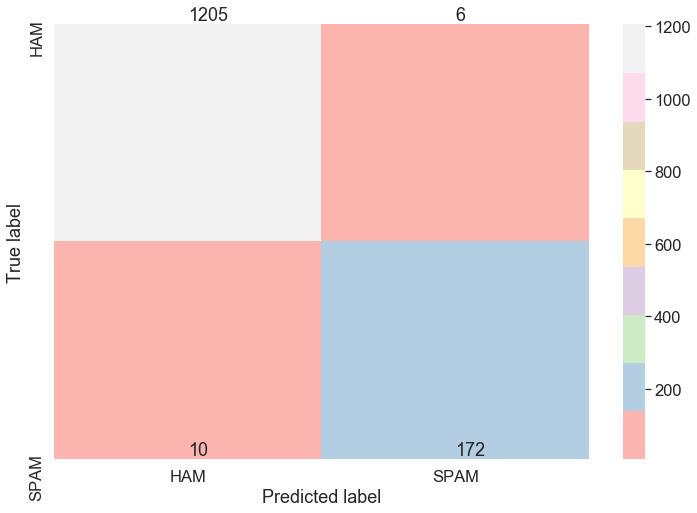

In [53]:
import seaborn as sns

df_cm = pd.DataFrame(confusion, index = ["HAM", "SPAM"],
                  columns = ["HAM", "SPAM"])
plt.figure(figsize = (12,8))
sns.set(font_scale=1.5)
annot_kws = {"ha": 'left',"va": 'bottom'}
hm = sns.heatmap(df_cm, cmap="Pastel1", fmt="d", annot=True, annot_kws=annot_kws)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()